In [1]:
# install packages if imports dont work

import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [2]:
# Setting working directory

print(f'Before={os.getcwd()}') 
#os.chdir('C:\\Users\\1412r\\sciebo\\GuiltAndResponsibility') # Set wd to \sciebo\GuiltAndResponsibility
#print(f'After={os.getcwd()}')

Before=C:\Users\1412r\sciebo\GuiltAndResponsibility\Codes
After=C:\Users\1412r\sciebo\GuiltAndResponsibility


In [3]:
# Get csv data

#print(os.getcwd())
path = 'SmithKrajbich2018/osfstorage-archive/socialchoicedata.csv'
df = pd.read_csv(path, header=0)

# Housekeeping
index = [i for i in range(1, len(df)+1)]
df.drop('Unnamed: 0', inplace=True, axis=1)
df.set_index(pd.Index(index), inplace=True)
df.head()
## df.isnull().sum() # checking for empty values along columns

,SubjectNumber,Trial,LeftRight,RT,ValueUpLeft,ValueUpRight,ValueLowerLeft,ValueLowerRight,TopRowPayoffs
1,10,1,2,0.85254,205,267,202,12,Me
2,10,2,1,0.79336,71,52,100,200,Me
3,10,3,2,0.63932,10,63,284,153,Me
4,10,4,2,1.24980,220,241,220,40,Me
5,10,5,2,0.75649,59,95,294,110,Me


In [4]:
# Accounting for switch in toprow payoff being mine or others'

df['TopRow'] = df['TopRowPayoffs']=='Me'

df['MeLeft'] = df['TopRow']*df['ValueUpLeft']+(1-df['TopRow'])*df['ValueLowerLeft'] # When top row is mine take my payoff
df['MeRight'] = df['TopRow']*df['ValueUpRight']+(1-df['TopRow'])*df['ValueLowerRight'] # otherwise take the bottom row payoff

df['OtherLeft'] = df['TopRow']*df['ValueLowerLeft']+(1-df['TopRow'])*df['ValueUpLeft']
df['OtherRight'] = df['TopRow']*df['ValueLowerRight']+(1-df['TopRow'])*df['ValueUpRight']


#df.head()

Step 1: Grid over alpha and beta

Step 2: Calculate U(L) and U(R) for every point in the matrix

Step 3: Find minimum error

In [5]:
# Grid parameters

steps = 11 ##### Input number of steps here
N = df.shape[0]

alpha_range = np.linspace(0, 0.5, steps, endpoint=True)
beta_range  = np.linspace(0, 0.75, steps, endpoint=True)
col = []

for alpha in alpha_range: 
    for beta in beta_range: 
        name = str(alpha), str(beta)
        col  = col + [name]

In [6]:
# Creating empty data frames

U_L = pd.DataFrame(index=pd.Index(index), columns=col)
U_R = pd.DataFrame(index=pd.Index(index), columns=col)

Calculate the grids as piece wise functions

In [7]:
# Left Grid

for alpha in alpha_range: 
    for beta in beta_range: 
        name = str(alpha), str(beta)
        U_L[name][df['MeLeft']>df['OtherLeft']]  = (1-beta)*df['MeLeft'][df['MeLeft']>df['OtherLeft']]+beta*df['OtherLeft'][df['MeLeft']>df['OtherLeft']]
        U_L[name][df['MeLeft']<df['OtherLeft']]  = (1-alpha)*df['MeLeft'][df['MeLeft']<df['OtherLeft']]+alpha*df['OtherLeft'][df['MeLeft']<df['OtherLeft']]
        U_L[name][df['MeLeft']==df['OtherLeft']] = df['MeLeft'][df['MeLeft']==df['OtherLeft']]

In [8]:
# Right Grid

for alpha in alpha_range: #5 steps
    for beta in beta_range: #5 steps
        name = str(alpha), str(beta)
        U_R[name][df['MeRight']>df['OtherRight']]  = (1-beta)*df['MeRight'][df['MeRight']>df['OtherRight']]+beta*df['OtherRight'][df['MeRight']>df['OtherRight']]
        U_R[name][df['MeRight']<df['OtherRight']]  = (1-alpha)*df['MeRight'][df['MeRight']<df['OtherRight']]+alpha*df['OtherRight'][df['MeRight']<df['OtherRight']]
        U_R[name][df['MeRight']==df['OtherRight']] = df['MeRight'][df['MeRight']==df['OtherRight']]

In [9]:
print(U_L.shape)
#U_L.head() # uncomment to see how U_L looks like

(7200, 121)


In [10]:
print(U_R.shape)
#U_R.head()

(7200, 121)


Smith and Krajbich dont drop rows with equal utilities; they assume right as default at equality. Uncomment the folowing two boxes to drop them

In [ ]:
## Checking if U(L) is equal to U(R)

#x = U_L==U_R # dataframe of trues and falses where left is equal to right
#x.sum(axis=1).sum() # Sum over rows and columns

In [ ]:
## Drop the rows where the utilities are equal

#U_L.drop(labels=U_L[x.sum(axis=1)!=0].index, inplace=True) # Drop rows where sum of columns in that row is not equal to zero
#U_R.drop(labels=U_R[x.sum(axis=1)!=0].index, inplace=True)

Create dataframe of ones (that is default choice is left)

Then for those rows where utility of right is more, edit the choice to right by multiplying by 2

In [11]:
# Creating dataframe of theoretical responses

N, total_col = U_L.shape
index = U_L.index
yhat = pd.DataFrame(np.ones((N, total_col)), index=index, columns=col) # Create a df of ones
yhat[U_L<U_R] = 2*yhat[U_L<U_R] # set to 2 where right gives more utility

print(yhat.shape)
#yhat.head()

(7200, 121)


Utilities of Left and Right are not equal for any comination of alpha and beta

(For now if ulities are same, left is taken as hypothetical choice by default)

In [12]:
# squared error

error = yhat.sub(df['LeftRight'][index], axis=0)
error = error**2
#error

(20/7/22: Subtract mean to make it mean squared error, so far its just squared error)

In [13]:
# Subject wise mean squared error for every combination of alpha and beta

start = 0
end = N
trials = 200

data = []
for i in range(start, end, trials):
    j = trials + i
    data = data + [error.iloc[i:j].sum()]
    
sq_error_sum = pd.DataFrame(data=data)

mse = sq_error_sum/trials
#mse

,"(0.0, 0.0)","(0.0, 0.075)","(0.0, 0.15)","(0.0, 0.22499999999999998)","(0.0, 0.3)","(0.0, 0.375)","(0.0, 0.44999999999999996)","(0.0, 0.525)","(0.0, 0.6)","(0.0, 0.6749999999999999)",...,"(0.5, 0.075)","(0.5, 0.15)","(0.5, 0.22499999999999998)","(0.5, 0.3)","(0.5, 0.375)","(0.5, 0.44999999999999996)","(0.5, 0.525)","(0.5, 0.6)","(0.5, 0.6749999999999999)","(0.5, 0.75)"
0,0.000,0.015,0.095,0.245,0.330,0.370,0.410,0.425,0.430,0.435,...,0.625,0.705,0.860,0.925,0.965,0.990,1.000,1.000,1.000,1.000
1,0.260,0.255,0.245,0.155,0.140,0.150,0.150,0.165,0.170,0.175,...,0.865,0.855,0.740,0.725,0.735,0.730,0.740,0.740,0.740,0.740
2,0.975,0.960,0.880,0.750,0.665,0.625,0.585,0.570,0.565,0.560,...,0.370,0.290,0.155,0.090,0.050,0.025,0.025,0.025,0.025,0.025
3,0.070,0.085,0.155,0.285,0.370,0.410,0.440,0.455,0.460,0.465,...,0.585,0.655,0.800,0.865,0.905,0.920,0.930,0.930,0.930,0.930
4,0.390,0.375,0.305,0.205,0.150,0.130,0.090,0.095,0.100,0.105,...,0.885,0.825,0.710,0.655,0.635,0.610,0.610,0.610,0.610,0.610
5,0.300,0.295,0.225,0.235,0.260,0.290,0.330,0.335,0.340,0.345,...,0.665,0.605,0.610,0.635,0.665,0.690,0.700,0.700,0.700,0.700
6,0.260,0.255,0.215,0.275,0.340,0.370,0.400,0.405,0.410,0.415,...,0.595,0.555,0.630,0.685,0.715,0.730,0.740,0.740,0.740,0.740
7,0.325,0.320,0.270,0.180,0.175,0.155,0.165,0.180,0.185,0.190,...,0.820,0.780,0.685,0.670,0.650,0.665,0.675,0.675,0.675,0.675
8,0.405,0.390,0.320,0.210,0.165,0.125,0.125,0.130,0.135,0.140,...,0.870,0.810,0.705,0.650,0.610,0.595,0.595,0.595,0.595,0.595
9,0.090,0.075,0.135,0.185,0.260,0.300,0.330,0.345,0.350,0.355,...,0.665,0.725,0.790,0.845,0.885,0.900,0.910,0.910,0.910,0.910


In [14]:
# Selecting the alpha beta pair which gives the least mse

min_mse = mse.idxmin(axis=1)


#--------------------------------------------------

# Average values of all min values

#min_mse = mse.min(axis=1)

#for x in range(36):
#    for y in (mse[x]==

In [15]:
# Creating list of alphas for each subject

obs_alpha = []

for x in min_mse:
    obs_alpha = obs_alpha + [x[0]]
    
obs_alpha = [float(x) for x in obs_alpha]
#obs_alpha

In [16]:
# Creating list of betas for each subject

obs_beta = []

for x in min_mse:
    obs_beta = obs_beta + [x[1]]
    
obs_beta = [float(x) for x in obs_beta]
#obs_beta

Text(0.5, 1.0, 'Alpha')

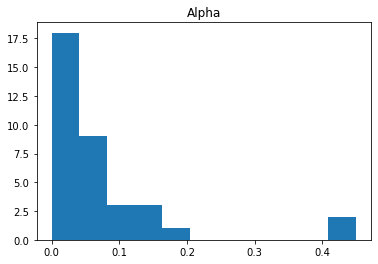

In [17]:
# Plotting alpha

plt.hist(obs_alpha, bins=11)
plt.title('Alpha')

Text(0.5, 1.0, 'Beta')

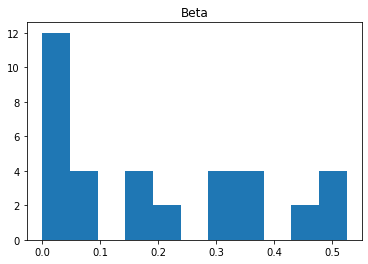

In [18]:
# PLotting beta

plt.hist(obs_beta, bins=11)
plt.title('Beta')